# Dimensionality Reduction

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sys
sys.path.append("../src")

from hvg import elect_genomic_features, plot_feature_selection

In [3]:
expression_df = pd.read_parquet("../data/expression_df_clean.parquet")
gdsc1_cell_lines_df = pd.read_parquet("../data/gdsc1_cell_lines_df_clean.parquet")
mutation_df = pd.read_parquet("../data/mutation_df_clean.parquet")

In [4]:
gene_cols = [col for col in expression_df.columns if col not in ['COSMIC_ID', 'GENE_SYMBOLS']]
print(f"Genes: {len(gene_cols)}")

expression_df[gene_cols] = expression_df[gene_cols].astype('float32')

Genes: 17419


# Highly Variable Genes [Feature Selection]

### An HVG is a gene that varies drastically among a distribution of genes. The version implemented is known as mean-variance trend HVG selection, similar to Seurat

GENOMIC FEATURE SELECTION

------------------------------------------------------------
PART 1: EXPRESSION HVG SELECTION
------------------------------------------------------------

Input expression genes: 17419
Mean range: [2.505, 13.169]
Variance range: [0.007, 15.533]
After filtering (mean > 0.01): 17419 genes
Mean-variance trend R²: 0.106
Residual range: [-1.078, 14.377]

✓ Selected 1000 expression HVGs

Top 10 expression HVGs:
                  mean   variance   residual
GENE_SYMBOLS                                
RPS4Y1        5.997825  15.533044  14.376678
KRT19         7.561498  15.297348  14.130043
VIM           9.716123  13.723386  13.066525
S100P         6.241192  13.352257  12.173111
TACSTD2       5.716338  12.878630  11.758301
TGFBI         7.033027  12.246521  11.047028
TM4SF1        7.804784  11.974901  10.834730
SRGN          5.902429  11.791555  10.646238
CAV1          8.274065  11.607012  10.541115
DKK 1.00      6.500137  11.466171  10.271320

----------------------

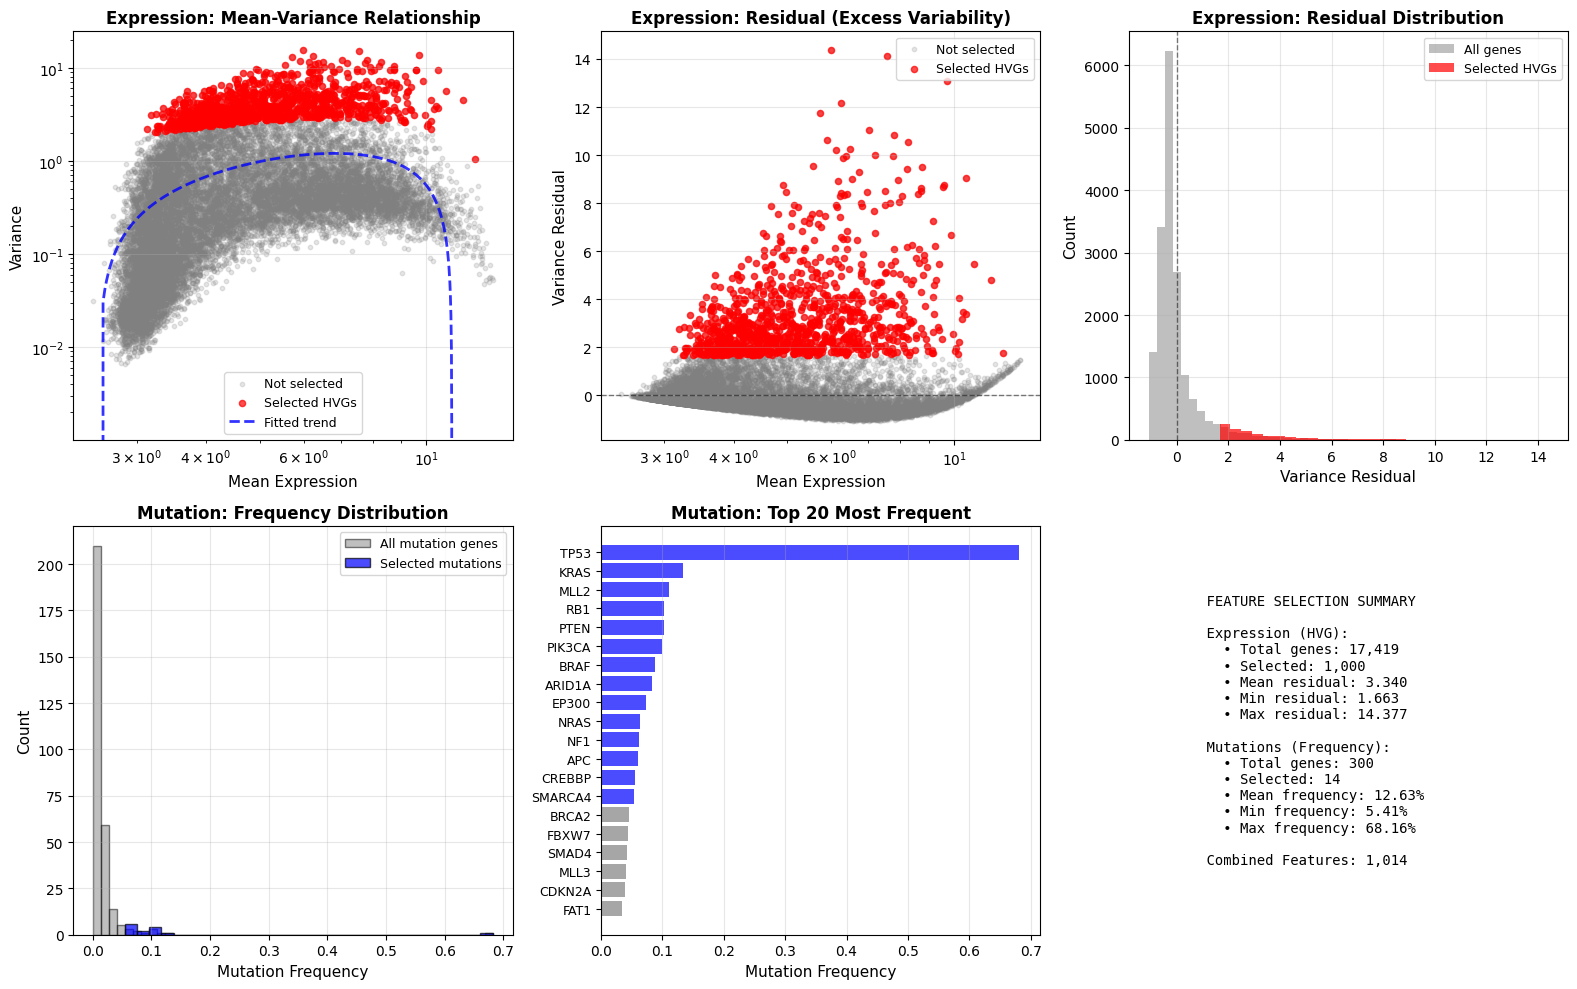

✓ Plots saved to genomic_feature_selection.png
Final features: 1000 expression + 14 mutation genes


In [5]:
# Both expression and mutations
selected_expr, selected_mut, expr_stats, mut_stats = select_genomic_features(expression_df=expression_df, mutation_df=mutation_df,
                                                                             n_expr=1000, min_expr_mean=0.01, degree=2, min_mut_freq=0.05, plot=True)

# Create features
expression_selected = expression_df[['COSMIC_ID'] + selected_expr].copy()
expression_renamed = expression_selected.rename(columns={g: f'{g}_expr' for g in selected_expr})

mutation_selected = mutation_df[['COSMIC_ID'] + selected_mut].copy()
mutation_renamed = mutation_selected.rename(columns={g: f'{g}_mut' for g in selected_mut})

# Combine
genomic_features = expression_renamed.merge(mutation_renamed, on='COSMIC_ID')

print(f"Final features: {len(selected_expr)} expression + {len(selected_mut)} mutation genes")

In [6]:
genomic_features.head()

,COSMIC_ID,RPS4Y1_expr,KRT19_expr,VIM_expr,S100P_expr,TACSTD2_expr,TGFBI_expr,TM4SF1_expr,SRGN_expr,CAV1_expr,...,PTEN_mut,RB1_mut,SMARCA4_mut,CREBBP_mut,ARID1A_mut,MLL2_mut,EP300_mut,APC_mut,BRAF_mut,PIK3CA_mut
0,906826,3.290730,12.168602,12.774622,4.060240,11.081974,5.285864,11.902697,10.441504,12.289793,...,0,0,0,0,0,0,0,0,0,0
1,687983,8.145208,2.890861,13.093635,3.309209,2.833932,3.178296,2.889431,2.706390,3.422951,...,0,0,1,0,0,0,0,0,0,0
2,910927,3.337390,11.185326,11.258884,10.165595,2.866781,3.095703,9.812016,3.130309,10.439181,...,1,0,1,0,1,0,0,0,0,1
3,1240138,3.019027,12.884291,11.461744,3.435135,2.781870,8.536860,11.488132,9.099688,9.393353,...,0,0,0,0,0,0,0,0,0,0
4,1240139,11.226059,4.965551,12.880485,3.359441,2.849831,6.992837,8.813685,9.237848,10.577919,...,1,0,0,0,0,0,0,0,0,0


In [7]:
mut_df = pd.merge(gdsc1_cell_lines_df, genomic_features, on='COSMIC_ID')
df = pd.merge(gdsc1_cell_lines_df, expression_selected, on='COSMIC_ID')

In [9]:
mut_df.to_parquet("../data/mut_df_clean.parquet")
df.to_parquet("../data/df_clean.parquet")

## Determining which drugs to predict
### Priorizing drugs with high representation in the dataset, and known for having mutations in genes like TP53, KRAS, etc. so that I can more accurately determine what type of impact adding 14 columns of mutation data will have on the models.

### Cisplatin acts as a negative control as the drug is not involved in a signaling pathway where a cascade can lead to mutations in these genes. Therefore, none of the top mutations occur in Cisplatin. 

### Trametinib was used in a lot of figures as an example of a predictive drug in Li et al. (2021). Similarly, Nutlin-3a (-) performed well in predicting drug sensitivity in the same paper.

### Selumetinib is very prevalent in this dataset and works by targeting a pathway that often has mutations like KRAS and BRAF, both included by thorugh select_genomic_features. PLX-4720 also has a high frequency and targets a mutation in BRAF. 

In [12]:
print(df["DRUG_NAME"].value_counts()['Trametinib']) 

849


In [13]:
print(df["DRUG_NAME"].value_counts()['Selumetinib']) 

1723


In [16]:
print(df["DRUG_NAME"].value_counts()['Nutlin-3a (-)']) 

899


In [14]:
df["DRUG_NAME"].value_counts().head(20)

DRUG_NAME
Cisplatin             1786
AZD7762               1784
SN-38                 1783
PLX-4720              1777
Avagacestat           1771
Afatinib              1765
Olaparib              1760
UNC0638               1752
SB505124              1749
AZD4547               1736
Pictilisib            1728
Doxorubicin           1725
Selumetinib           1723
AKT inhibitor VIII    1717
Refametinib           1714
AZD6482               1712
Gemcitabine           1712
JQ1                   1711
CHIR-99021            1708
Bicalutamide          1672
Name: count, dtype: int64